In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
import time
np.random.seed(2)


In [2]:
def load_cls(fname):
    return np.array(pickle.load(open(fname,"rb")))

In [3]:
path = "D:/"
trainSamples = 500
n_iter = 100 
n_trainSamples = [100,250,500,750,1000,1250,1500]
#n_trainSamples = [100,500,1000,10000,20000,50000,75000]

In [4]:
X_train = load_cls(path+"X_train_tokens.p")[:trainSamples]
X_val_cls = load_cls(path+"X_val_tokens.p")

y_train = load_cls(path+"y_train.p")[:trainSamples]
y_val = load_cls(path+"y_val.p")

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

def my_preprocessor(doc):
    return doc

# tokenize the doc and lemmatize its tokens
def my_tokenizer(doc):
    return doc

custom_vec = CountVectorizer(preprocessor=my_preprocessor, tokenizer=my_tokenizer)
cwm = custom_vec.fit_transform(X_train)
tokens = custom_vec.get_feature_names()

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Perceptron
from sklearn.calibration import CalibratedClassifierCV

In [7]:
feature_pipeline = Pipeline([
('vect',  CountVectorizer(min_df=.0025, max_df=0.25, ngram_range=(1,3),preprocessor=my_preprocessor, tokenizer=my_tokenizer)),
('tfidf', TfidfTransformer()),
])

In [8]:
X_train_f = feature_pipeline.fit_transform(X_train)
X_val_f =feature_pipeline.transform(X_val_cls)

In [9]:
from sklearn.model_selection import GridSearchCV
parameters = {
     'alpha': [0.001, 0.01, 0.1, 1,0.0001],
    'tol': [0.001,0.0001],
    'validation_fraction' : [0.05,0.1,0.2],
 }

In [10]:
lr_clf = GridSearchCV(Perceptron(max_iter= n_iter, n_jobs=-1), 
                      parameters,n_jobs=-1, verbose=4, iid=True)

In [11]:
model = lr_clf.fit(X_train_f, y_train)

C:\Users\prash\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  67 out of  90 | elapsed:    3.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.4s finished


In [12]:
model.best_score_

0.512

In [13]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'alpha': 0.001, 'tol': 0.001, 'validation_fraction': 0.05}
alpha: 0.001
tol: 0.001
validation_fraction: 0.05


In [14]:
pickle.dump(model,open("Perceptron_"+str(trainSamples)+"_"+str(n_iter)+".pkl",'wb'))

In [15]:
X_test = load_cls(path+"X_test_tokens.p")
y_test = load_cls(path+"y_test.p")

In [16]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
valAccuracy = []
testAccuracy = []
mrrScore = []
precisionAt1 = []
precisionAt3 = []

# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel = CalibratedClassifierCV(Perceptron(max_iter= n_iter, n_jobs=-1,alpha=model.best_params_['alpha'],tol=model.best_params_['tol'],
                          validation_fraction=model.best_params_['validation_fraction']),cv=10)

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    X_train_f = feature_pipeline.fit_transform(X_train[:eachTrain])
    bestModel.fit(X_train_f,y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    X_val_f = feature_pipeline.transform(X_val_cls)
    preds_val = bestModel.predict(X_val_f)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    X_test_f = feature_pipeline.transform(X_test)
    preds_test = bestModel.predict(X_test_f)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_f)
    qid2c,qid2indexmap = load_ranking("test")
    print (mrrwrapper(qid2c,qid2indexmap,preds_test_probs))
    mrr, pAt1, pAt3 = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    precisionAt1.append(pAt1)
    precisionAt3.append(pAt3)
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)
print (precisionAt1)
print (precisionAt3)

SampleSize: 100
Train Time:0.13 sec
Validation Accuracy: 49.61%
Validation Time:4.07 sec
Test Accuracy: 50.29%
Test Time:4.15 sec
(0.4062931697931698, 0.174, 0.4686666666666667)
MRR: 0.4062931697931698
MRR Time:1.06 sec
SampleSize: 250
Train Time:0.25 sec
Validation Accuracy: 50.21%
Validation Time:4.20 sec
Test Accuracy: 49.97%
Test Time:4.22 sec
(0.4264793650793655, 0.17866666666666667, 0.5446666666666666)
MRR: 0.4264793650793655
MRR Time:1.11 sec
SampleSize: 500
Train Time:0.38 sec
Validation Accuracy: 52.33%
Validation Time:4.23 sec
Test Accuracy: 52.28%
Test Time:4.23 sec
(0.4507111111111123, 0.20933333333333334, 0.57)
MRR: 0.4507111111111123
MRR Time:0.98 sec
SampleSize: 750
Train Time:0.38 sec
Validation Accuracy: 52.33%
Validation Time:4.32 sec
Test Accuracy: 52.28%
Test Time:4.29 sec
(0.4507111111111123, 0.20933333333333334, 0.57)
MRR: 0.4507111111111123
MRR Time:1.09 sec
SampleSize: 1000
Train Time:0.42 sec
Validation Accuracy: 52.33%
Validation Time:4.28 sec
Test Accuracy: 5

In [19]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("Perceptron_Accuracy.png")
    plt.show()

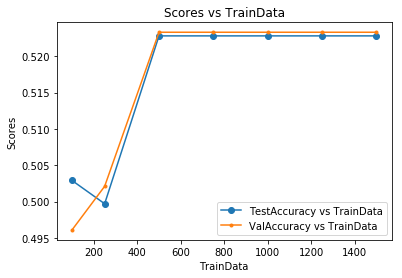

In [20]:
accuracyVisualization()

In [21]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("Perceptron_Mrr.png")
    plt.show()

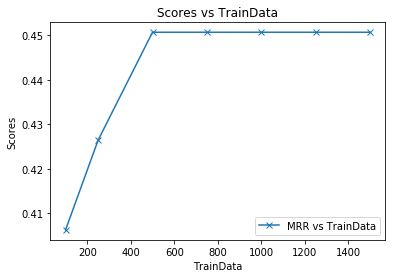

In [22]:
mrrVisualization()